## Vehicle Detection Project
The goals / steps of this project are the following project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test\_video.mp4 and later implement on full project\_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Histogram of Oriented Gradients (HOG)
* Read vehicle and non-vehicle images
* Show each examle of image
* Extract HOG features using YCrCb color space and HOG parameters and show the examples of output

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import numpy as np
import cv2
import math
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

Number of car images:  8792
Number of non-car images:  8968


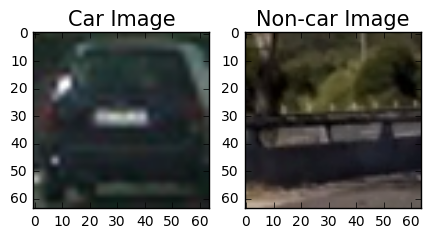

In [10]:
car_files = glob.glob('/home/kazuhiro/TrainingImage_UDACITY/vehicles/*/*.png')
noncar_files = glob.glob('/home/kazuhiro/TrainingImage_UDACITY/non-vehicles/*/*.png')

print("Number of car images: ",len(car_files))
print("Number of non-car images: ",len(noncar_files))

img_car = mpimg.imread(car_files[0])
img_noncar = mpimg.imread(noncar_files[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5))
ax1.imshow(img_car)
ax1.set_title('Car Image',fontsize=15)
ax2.imshow(img_noncar)
ax2.set_title('Non-car Image', fontsize=15)

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Hog Feature
Here is an example using the YCrCb color space and HOG parameters of orientations=9, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

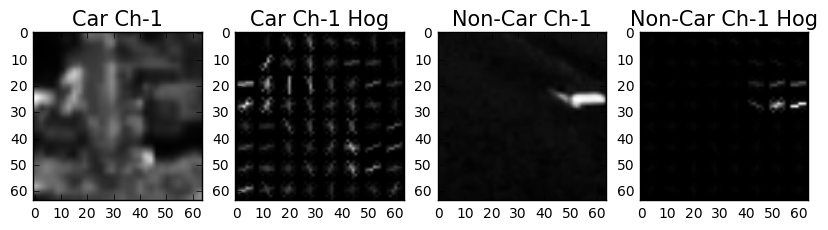

In [12]:
colorspace = 'YCRCB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

caridx = np.random.randint(0,len(car_files)-1)
noncaridx = np.random.randint(0,len(noncar_files)-1)

carimg = mpimg.imread(car_files[caridx])
carimg = cv2.cvtColor(carimg, cv2.COLOR_RGB2YCrCb)

car_ch1 = carimg[:,:,0]
car_ch2 = carimg[:,:,1]
car_ch3 = carimg[:,:,2]

hog_feat1, hog_img1 = get_hog_features(car_ch1, orient, pix_per_cell, cell_per_block, vis=True)
hog_feat2, hog_img2 = get_hog_features(car_ch2, orient, pix_per_cell, cell_per_block, vis=True)
hog_feat3, hog_img3 = get_hog_features(car_ch3, orient, pix_per_cell, cell_per_block, vis=True)

noncarimg = mpimg.imread(noncar_files[noncaridx])
noncarimg = cv2.cvtColor(noncarimg, cv2.COLOR_RGB2YCrCb)

noncar_ch1 = noncarimg[:,:,0]
noncar_ch2 = noncarimg[:,:,1]
noncar_ch3 = noncarimg[:,:,2]

noncar_hog_feat1, noncar_hog_img1 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)
noncar_hog_feat2, noncar_hog_img2 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)
noncar_hog_feat3, noncar_hog_img3 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)


f, ((ax1, ax2,ax3, ax4)) = plt.subplots(1,4,figsize=(10,5))
ax1.imshow(car_ch1,cmap='gray')
ax1.set_title('Car Ch-1',fontsize=15)
ax2.imshow(hog_img1,cmap='gray')
ax2.set_title('Car Ch-1 Hog',fontsize=15)
ax3.imshow(noncar_ch1,cmap='gray')
ax3.set_title('Non-Car Ch-1',fontsize=15)
ax4.imshow(noncar_hog_img1,cmap='gray')
ax4.set_title('Non-Car Ch-1 Hog',fontsize=15)

## Training
* Combined Hog feature, Binned Color features,and Color Histogram feature
* Tweak parameters for extracting Hog features
    * colorspace = 'YCRCB'
    * orient = 9
    * pix_per_cell = 8
    * cell_per_block = 2
    * hog_channel = "ALL"
* Data Preparaion
    * Normilization for combined features
    * Split data into 80% training data and 20% test data and shuffled
* Used Linear SVM as supervised learning model

In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCRCB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range = hist_range)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(np.concatenate((hog_features,spatial_features,hist_features)))
    # Return list of feature vectors
    return features

In [14]:
#Tweak parameters 
colorspace = 'YCRCB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32

car_features = extract_features(car_files, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
noncar_features = extract_features(noncar_files, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
#save X_scaler
joblib.dump(X_scaler,'X_scaler.p')
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)

#save svc model
joblib.dump(svc,'svc.p')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
182.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
1.29369 Seconds to predict 10 labels with SVC


## Sliding Window Technique
* Extract HOG features at once for entire image to process efficiently
* 75% overlap and scale 1.5-1.8 could work the best to detect cars and reduce noises as a result of my experiment
* 64x64 window is used for searching 

## How pipeline works
* Per the 64x64 window, function find_cars use YCrCb 3-channel HOG features, spatial_features,and hist_features to predict car image and non-car image. If car image is found, it draws the box on the image as much as possible.
* At this stage multiple detections occur and false positives are found. So I built a heat-map from these detections in order to combine overlapping detections and remove false positives. The "hot" parts of the map indicates where the cars are. Applying threshold, I rejected areas affected by false positives and multiple detections.
* At last a label function labels each car and I could draw the boundary boxes for each car detected. 

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img,bbox_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

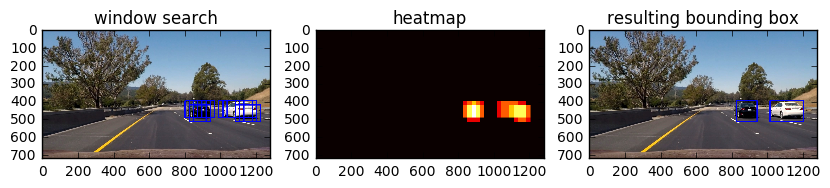

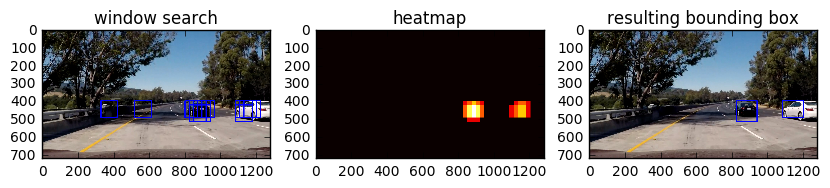

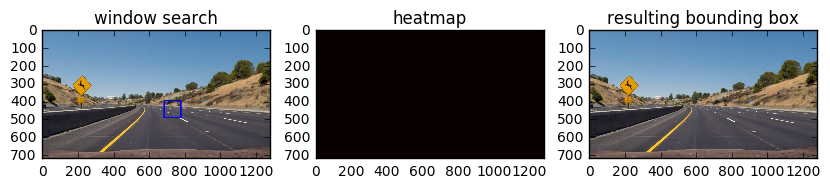

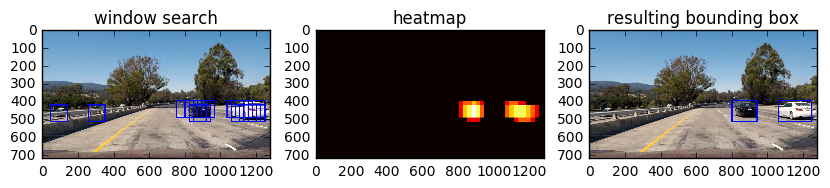

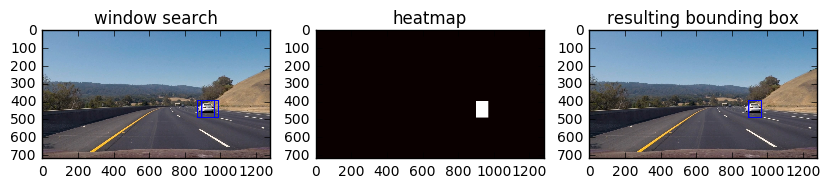

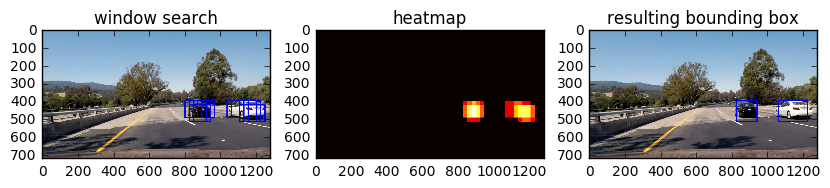

In [20]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32

ystart = 400
ystop = 656
scales = [1.47]

threshold = 1.5


#restore svc model and X_scaler
svc = joblib.load('svc.p')
X_sclaer = joblib.load('X_scaler.p')

test_files = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/p5_vehicle_detection/test_images/*.jpg')


for test_file in test_files:
    test_img = mpimg.imread(test_file)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    
    curr_img = np.copy(test_img)
    for curr_scale in scales:
        curr_img,box_list = find_cars(curr_img, ystart, ystop, curr_scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat,box_list)
        heat = apply_threshold(heat,threshold)
        heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
    
    ax1.imshow(curr_img)
    ax1.set_title('window search')
    
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('heatmap')
    
    ax3.imshow(draw_img)
    ax3.set_title('resulting bounding box')

## Video
* Load svc model and X_scaler
* Set necesarry parameters. I set scale to 1.47 because it produced the nice result.
* Used average of heat matrixes from the overlapped boudary boxes and threshhold 0.8 per 2 frames to remove false positives as much as possible. 
* Used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap per 2 frames and showed detected cars in rectangles. 

In [171]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#restore svc model and X_scaler
svc = joblib.load('svc.p')
X_sclaer = joblib.load('X_scaler.p')

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32
ystart = 400
ystop = 656
scales = [1.47]
threshold = 0.8
heat_list = []

class HeatTrack:
    def __init__(self):
        self.detected = False
        self.curr_heat = None


def process_image(img):
    number_of_frame = 2
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    curr_img = np.copy(img)
    for curr_scale in scales:
        output_img,box_list = find_cars(curr_img, ystart, ystop, curr_scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat,box_list)
        #heat_thresh = apply_threshold(heat,threshold)
        #heatmap = np.clip(heat_thresh, 0, 255)
        #labels = label(heatmap)
        
    heat_list.append(heat)

    #Take average of heatmap per cetain number of frames
    if(len(heat_list)==number_of_frame):
        heat_list.clear()
        for h in heat_list:
            heat += h
        heat = heat/number_of_frame
        heat_track.curr_heat = heat
        
    if(heat_track.detected == False):
        heat_track.curr_heat = heat
        heat_track.detected = True
    
    heat_thresh = apply_threshold(heat_track.curr_heat,threshold)
    heatmap = np.clip(heat_thresh, 0, 255)
    labels = label(heatmap)
    result_img = draw_labeled_bboxes(np.copy(img), labels)
    return result_img

## Test Video Output 

In [172]:
heat_track = HeatTrack()
white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:30<00:00,  1.12it/s]      | 1/39 [00:00<00:24,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 17s, sys: 3.67 s, total: 1min 21s
Wall time: 34.2 s


## Project Video Output

In [173]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [23:38<00:01,  1.36s/it]    | 1/1261 [00:00<14:10,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 46min 43s, sys: 2min 1s, total: 48min 44s
Wall time: 23min 45s


## Discussion

For training classifiers, it was the best accuracy when I used YCrCb 3-channel HOG features, spatially binned color and histograms of color in the feature vector. It resulted the test accuracy of SVC as 99.04%. 

I had to imprement a number of experiments because it was difficult to reomve the false positives at high accuracy. If I decrease the threshold for the heatmap, it detects more false positives. If I incresase it, it does not detect cars well. 

Even though it seems to work well in the static image, it does not work as well for video clip. So I used average of heat matrix per 2 frames to avoid false positives. I assume it avoids false positives occuring at one frame and output will be more robust. 

I still see some fales positives on the other lane and some problems when the car is near the horizon. When the car approaches horizon, it is not being detected. Probably I can adjust it by modifying parameters such as thresh hold or using multiple scales.  